In [ ]:
import os
try:
	os.chdir(os.path.join(os.getcwd(), 'tensorflow'))
	print(os.getcwd())
except:
	pass

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

In [ ]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

In [ ]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))


In [3]:
def read_extracted_data(filename):
    """Read file to tensorflow"""
    with open(filename, 'r') as f:
        data = tf.compat.as_str(f.read()).split()
    return data

words = read_extracted_data('/home/jovyan/work/websraping/allebarna.txt')
type(words)

list

In [4]:
vocabulary_size = 3000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.


Most common words (+UNK) [['UNK', 368], ('Alle', 1364), ('unntatt', 1343), ('barna', 1337), ('var', 711)]
Sample data [1, 3, 15, 1222, 2, 233, 6, 15, 1223, 1]


In [5]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])


data: ['Alle', 'barna', 'ble', 'etterforsker,', 'unntatt', 'Abel,', 'han', 'ble']

with num_skips = 2 and skip_window = 1:
    batch: ['barna', 'barna', 'ble', 'ble', 'etterforsker,', 'etterforsker,', 'unntatt', 'unntatt']
    labels: ['Alle', 'ble', 'barna', 'etterforsker,', 'unntatt', 'ble', 'etterforsker,', 'Abel,']

with num_skips = 4 and skip_window = 2:
    batch: ['ble', 'ble', 'ble', 'ble', 'etterforsker,', 'etterforsker,', 'etterforsker,', 'etterforsker,']
    labels: ['etterforsker,', 'barna', 'Alle', 'unntatt', 'unntatt', 'Abel,', 'barna', 'ble']


In [6]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))


Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [7]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        #print(log)
  final_embeddings = normalized_embeddings.eval()


Initialized
Average loss at step 0: 6.236552
Average loss at step 2000: 2.583636
Average loss at step 4000: 1.872673
Average loss at step 6000: 1.734772
Average loss at step 8000: 1.681258
Average loss at step 10000: 1.669287
Average loss at step 12000: 1.640676
Average loss at step 14000: 1.636037
Average loss at step 16000: 1.617888
Average loss at step 18000: 1.620462
Average loss at step 20000: 1.606860
Average loss at step 22000: 1.611334
Average loss at step 24000: 1.600056
Average loss at step 26000: 1.602311
Average loss at step 28000: 1.596546
Average loss at step 30000: 1.594266
Average loss at step 32000: 1.599356
Average loss at step 34000: 1.585437
Average loss at step 36000: 1.597145
Average loss at step 38000: 1.580837
Average loss at step 40000: 1.591766
Average loss at step 42000: 1.579163
Average loss at step 44000: 1.586219
Average loss at step 46000: 1.581691
Average loss at step 48000: 1.582562
Average loss at step 50000: 1.578858
Average loss at step 52000: 1.5810

In [18]:
final_embeddings.shape

(3000, 128)

In [8]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

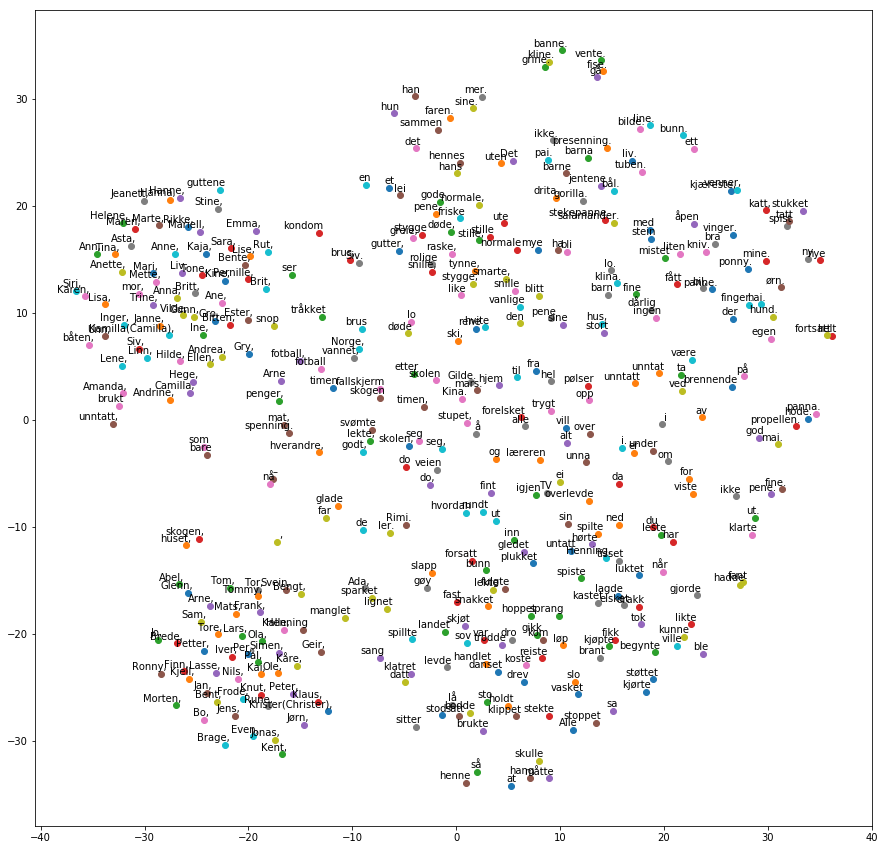

In [9]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

In [ ]:
TSNE

In [35]:
v1 = np.random.rand(100)
v2 = np.random.rand(100)
v3 = np.random.rand(100)
v4 = np.random.rand(100)
v5 = np.random.rand(100)

import pandas as pd

df = pd.DataFrame({'V1': v1, 'V2': v2, 'V3': v3, 'V4': v4, 'V5': v5})

In [36]:
df.head()

,V1,V2,V3,V4,V5
0,0.251225,0.626100,0.805034,0.671874,0.124090
1,0.423527,0.617728,0.284559,0.664317,0.123107
2,0.727775,0.905392,0.866991,0.805559,0.782921
3,0.575146,0.311181,0.101692,0.409059,0.910785
4,0.958008,0.634981,0.227224,0.604311,0.164343


In [37]:
tsne = TSNE(n_components=2, verbose=1)

In [38]:
two_d_embeddings = tsne.fit_transform(df)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.406603
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.828182
[t-SNE] KL divergence after 1000 iterations: 0.494101


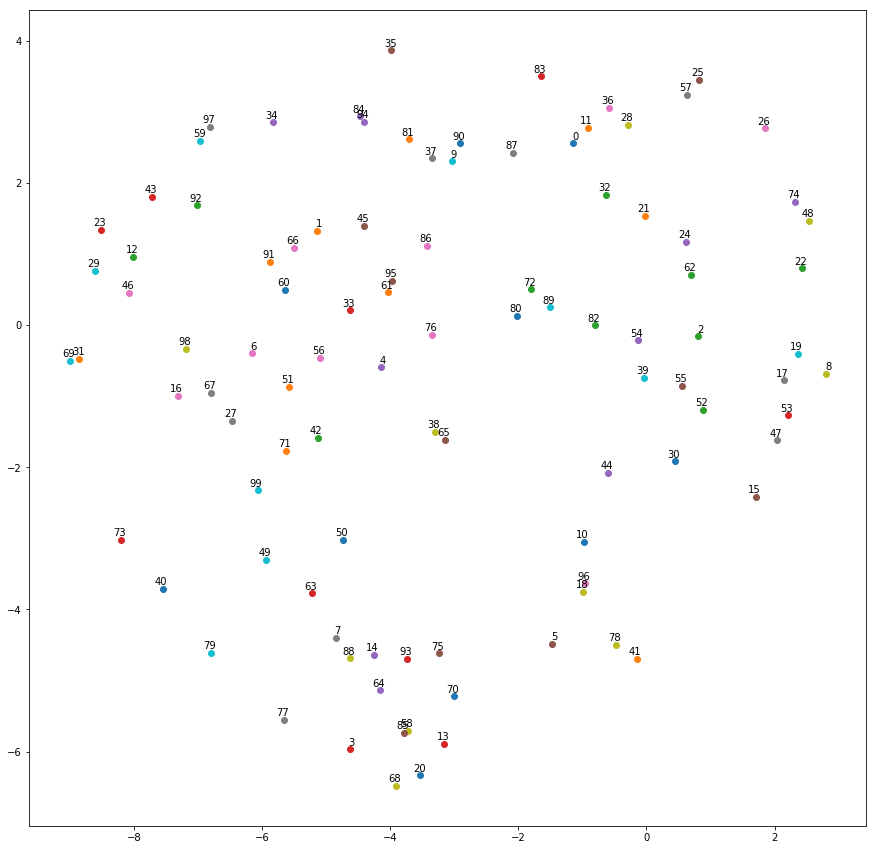

In [40]:
plot(two_d_embeddings, range(0, 100))